# Cálculo del rezago habitacional en México

## Introducción

El presente notebook tiene como objetivo desarrollar parte de la metodología del rezago habitacional en México. Ésta se utiliza para cuantificar el problema de la vivienda en nuestro país. Esta ha sido utilizada por la SEDATU y la Comisión Nacional de Vivienda tanto para la elaboración de planes y programas así como para la definición de poblaciones objetivo de programas presupuestarios.

Si bien el CONEVAL ha desarrollado también una medición similar (calidad y espacios de la vivienda) incorporándola a su metodología de pobreza multidimensional, la del rezago habitacional abarca un mayor abanico de condiciones que la hacen una medición más estricta.

### Comenzaré por desglosar los pasos para hacer la medición en Python.

Es importante señalar que para hacer esta medición, se utiliza la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH), no obstante, cualquier instrumento que cuente con las variables requeridas, servirá para hacer la medición

Se importarán la paquetería necesaria

In [13]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
from urllib.request import urlopen
import matplotlib.pyplot as plt
from zipfile import ZipFile

Para los datos, utilizaremos la liga del INEGI en donde se encuentran los datos:

In [14]:
##URL tabla viviendas de ENIGH
zipurl="https://www.inegi.org.mx/contenidos/programas/enigh/nc/2018/microdatos/enigh2018_ns_viviendas_csv.zip"

Para trabajar con nuestros datos, cambiaremos el directorio de trabajo. Ustedes pueden ubicarlo donde mejor les convenga:

In [19]:
dir=os.chdir("C:/Users/ALIENWARE/Documents/enigh")

Descomprimimos y leemos el archivo

In [21]:
zipresp = urlopen(zipurl)
tempzip = open("tempfile.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("tempfile.zip")
zf.extractall(dir)
zf.close()

##Leer archivo csv
vivi=pd.read_csv("viviendas.csv")

Una vez que tenemos el archivo cargado, comenzaremos por hacer las transformaciones y cálculos necesarios.
Primero construiremos la variable de entidad federativa con la del folio de la vivienda. Con base en el largo, sabremos cuántos dígitos extraer y, posteriormente, se le incorporará un cero a las entidades de. 1 al 9.

In [22]:
#Crear variable de clave de entidad federativa

##Obtener el largo del folioviv
vivi['largo'] = vivi['folioviv'].astype(str).map(len)

##Extraer la clave de entidad
vivi['cve_ent'] = np.where((vivi['largo']== 9), 
vivi.folioviv.astype(str).str[:1],vivi.folioviv.astype(str).str[:2] )

##Agregar cero a la clave de la entidad
vivi['cve_ent'] = vivi['cve_ent'].str.zfill(2)

Una vez realizado esto, cruzaremos esta clave de entidad que hemos construido con el catálogo de nombres de entidad del INEGI. En mi caso, lo tengo en mi computadora pero ustedes pueden bajarlo de la página: https://www.inegi.org.mx/app/ageeml/

In [23]:
##Llamar al catálogo de entidades
cata=pd.read_excel("C:/Users/ALIENWARE/Documents/bolet/estatal/claves.xlsx", engine="openpyxl")


Dado que la tabla que tengo es a nivel municipal y únicamente llegaremos hasta nivel entidad, debemos adecuarla para poder cruzarlo con nuestros datos:

In [24]:
##transformar a texto la clave de entidad
cata['cve_ent'] = cata['cve_ent'].astype(str)
cata['cve_ent'] = cata['cve_ent'].str.zfill(2)
##Dado que es una tabla a nivel municipal, hacer el subset para dejar únicamente los datos de las 32 entidades
cata=cata[["cve_ent","nom_ent"]]
cata= cata.drop_duplicates(subset=['cve_ent'])


Una vez realizado lo anterior, se procede a hacer el match y corroboramos:

In [25]:
##pegar nombres
vivi= pd.merge(vivi,cata,how="left",left_on="cve_ent",right_on="cve_ent")

In [26]:
vivi

,folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,...,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar,largo,cve_ent,nom_ent
0,100013601,1,8,10,3,42,,1,2,4,...,1001,1,3,2,1,175,0,9,01,Aguascalientes
1,100013602,1,8,10,3,40,,1,2,5,...,1001,1,3,2,1,175,0,9,01,Aguascalientes
2,100013603,1,8,10,3,50,,1,2,2,...,1001,1,3,2,1,175,0,9,01,Aguascalientes
3,100013604,1,8,10,3,45,,1,2,2,...,1001,1,3,2,1,175,0,9,01,Aguascalientes
4,100013606,1,8,10,3,40,,1,2,3,...,1001,1,3,2,1,175,0,9,01,Aguascalientes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73400,3260798902,1,8,10,2,3,,1,2,1,...,32046,4,2,543,8395,192,0,10,32,Zacatecas
73401,3260798903,1,7,8,2,67,,1,2,1,...,32046,4,2,543,8395,192,0,10,32,Zacatecas
73402,3260798904,1,7,10,2,40,,1,2,3,...,32046,4,2,543,8395,192,0,10,32,Zacatecas
73403,3260798905,1,8,4,2,,1,1,2,3,...,32046,4,2,543,8395,192,0,10,32,Zacatecas


## Cálculo del rezago habitacional

Una vez que tenemos nuestros datos, debemos ajustar nuestra variable de material de piso para poder utilizarla:

In [29]:
##Mutar material de pisos a numérico
vivi['mat_pisos'] = pd.to_numeric(vivi['mat_pisos'],errors='coerce')

Ahora, establecemos las condiciones que definen al rezago habitacional:

In [30]:
##Condiciones de rezago

condiciones=[(vivi["tot_resid"]/vivi["num_cuarto"]>2.5) | 
((vivi["mat_pared"]>=1) & (vivi["mat_pared"]<=6)) |
((vivi["mat_techos"]>=1) & (vivi["mat_techos"]<=4)) |
((vivi["mat_techos"]>=6) & (vivi["mat_techos"]<=7)) |
(vivi["mat_techos"]==9) |
(vivi["mat_pisos"]==1) |
(vivi["excusado"]==2)]

opciones=[1]

vivi["rezago"]=np.select(condiciones,opciones)

vivi["rezago"]=np.where(vivi["rezago"]==1,"En rezago","Fuera de rezago")

Una vez establecidas las condiciones, hacemos la crosstab:

In [31]:
##Calcular rezago habitacional total
rez=pd.crosstab(index=vivi.rezago, 
                           columns="count",
                           values=vivi.factor,
                           aggfunc=np.sum, margins=False, 
                           margins_name="Total")

In [32]:
rez

col_0,count
rezago,
En rezago,9409845
Fuera de rezago,24745770


Ahora, procederemos a hacer el gráfico:

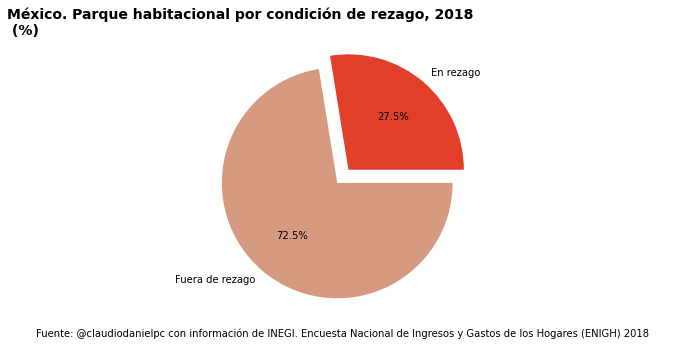

In [34]:
# Colores de gráfico
colors = ["#E13F29", "#D69A80"]

##Gráfica del rezago habitacional total
rez.plot.pie(subplots=True,figsize=(12, 5),
autopct='%1.1f%%',explode=(0, 0.15),colors=colors)
#Título
plt.title('México. Parque habitacional por condición de rezago, 2018 \n (%)',
fontsize=14,fontweight="bold", loc="left")
plt.legend("",frameon=False)
plt.axis('equal')
plt.ylabel('')
plt.xlabel('\nFuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2018')
##Guardar y mostrar la gráfica
plt.savefig("rezago.png",format="png",dpi=600,transparent=False)
plt.show()

Hemos obtenido el porcentaje total de rezago habitacional en nuestro país; es decir, el porcentaje de viviendas que se encuentran con materiales deteriorados, regulares o con precariedad de espacios. Para ver más detalle de la metodología, se puede consultar este documento: https://sniiv.conavi.gob.mx/doc/analisis/2017/An%C3%A1lisis_del_rezago_habitacional_2008_2016.pdf

Ahora, se calculará la participación de cada entidad federativa al rezago habitacional: 

In [35]:
##Filtrar rezago
entidad = vivi[vivi['rezago']=="En rezago"]

##Calcular rezago habitacional por entidad
rezent=pd.crosstab(index=entidad.nom_ent, 
                           columns=entidad.rezago,
                           values=entidad.factor,
                           aggfunc=np.sum, margins=False, 
                           margins_name="Total")

##Ordenar de mayor a menor
rezent.sort_values('En rezago',inplace=True)
##Calcular porcentaje del total
rezent["pct"]=rezent["En rezago"]/sum(rezent["En rezago"])*100
##Dejar solo la variable que se graficará
rezent=rezent[["pct"]]

In [36]:
rezent

rezago,pct
nom_ent,
Aguascalientes,0.191013
Tlaxcala,0.429083
Baja California Sur,0.748822
Colima,0.757728
Durango,0.882852
Sinaloa,0.910695
Querétaro,0.989581
Nayarit,1.001047
Zacatecas,1.171592


Graficamos:

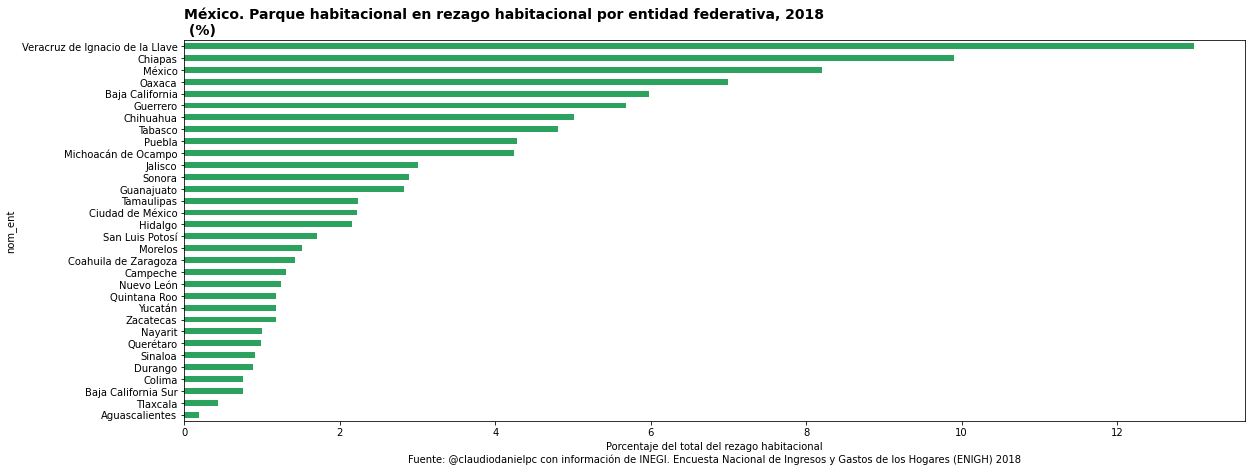

In [37]:
##Gráfica
rezent.plot.barh(figsize=(19, 7),color="#2ca25f")
#Título
plt.title('México. Parque habitacional en rezago habitacional por entidad federativa, 2018 \n (%)',
fontsize=14,fontweight="bold", loc="left")
plt.legend("",frameon=False)
plt.xlabel('Porcentaje del total del rezago habitacional\nFuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2018')
##Guardar y mostrar la gráfica
plt.savefig("rezagoent.png",format="png",dpi=600,transparent=False)
plt.show()


Por último, obtendremos el porcentaje de rezago habitacional de cada entidad federativa en relación con su parque habitacional:

In [39]:
##Calcular rezago habitacional en cada entidad


rezent2=pd.crosstab(index=vivi.nom_ent, 
                           columns=vivi.rezago,
                           values=vivi.factor,
                           aggfunc=np.sum, margins=True, 
                           margins_name="Nacional")


##Calcular porcentaje del total
rezent2["pct"]=rezent2["En rezago"]/rezent2["Nacional"]*100
##Ordenar de mayor a menor
rezent2.sort_values('pct',inplace=True)

##Dejar solo la variable que se graficará
rezent2=rezent2[["pct"]]
rezent2

rezago,pct
nom_ent,
Aguascalientes,5.294069
Nuevo León,7.918806
Ciudad de México,8.020509
Sinaloa,10.039504
Tlaxcala,12.016273
Jalisco,12.756749
Coahuila de Zaragoza,15.987872
México,16.362999
Querétaro,16.598604


Y hacemos la gráfica:

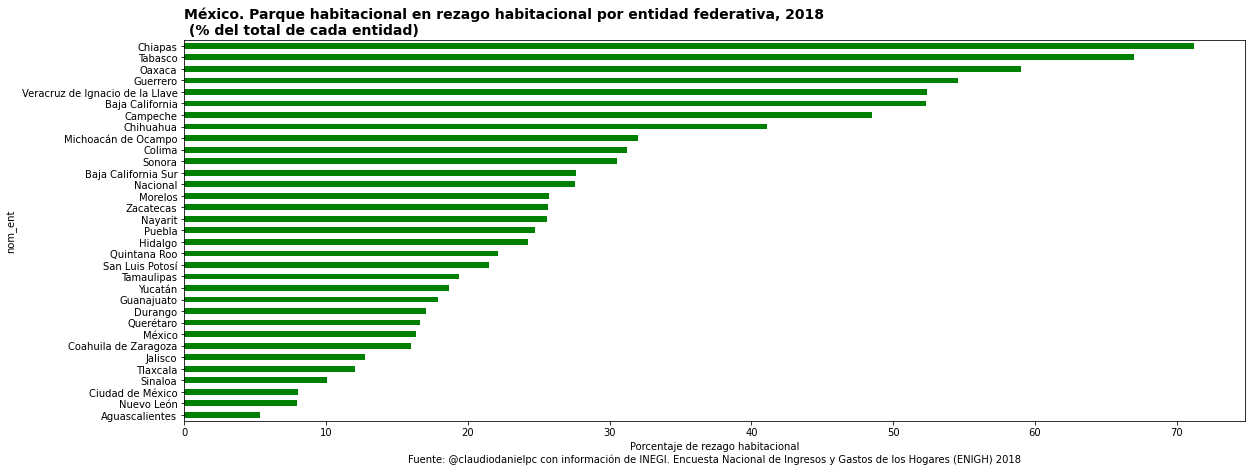

In [41]:
##Gráfica
rezent2.plot.barh(figsize=(19, 7),color="green")
#Título
plt.title('México. Parque habitacional en rezago habitacional por entidad federativa, 2018 \n (% del total de cada entidad)',
fontsize=14,fontweight="bold", loc="left")
plt.legend("",frameon=False)
plt.xlabel('Porcentaje de rezago habitacional\nFuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2018')
##Guardar y mostrar la gráfica
plt.savefig("rezagoent2.png",format="png",dpi=600,transparent=False)
plt.show()

Estos datos que obtuvimos los pueden corroborar en la página del Sistema Nacional de Información e Indicadores de Vivienda de CONAVI:https://sniiv.conavi.gob.mx/demanda/rezago_estatal.aspx 